# 1. Data Preperation

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from mgwr.gwr import MGWR
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from libpysal.weights import KNN
from esda.moran import Moran
import logging
import matplotlib.pyplot as plt
from shapely import is_valid, make_valid
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold
from mgwr.gwr import MGWR
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist  # Import cdist for distance calculations



In [2]:
#Load parks data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'building_density',
       'building_proximity', 'lst_buffer_30m', 'lst_buffer_60m',
       'lst_buffer_90m', 'lst_buffer_120m', 'lst_buffer_150m',
       'lst_buffer_180m', 'lst_buffer_210m', 'lst_buffer_240m',
       'lst_buffer_270m', 'lst_buffer_300m', 'lst_park', 'park_pixel_count',
       'lst_surrounding_mean', 'lst_reduction', 'lst_data', 'cubic_coeffs',
       'r_squared', 'PCD', 'PCI', 'PCA', 'PCE', 'PCD_source', 'geometry'],
      dtype='object')


## 1. Checking parks selection criteria

- Remove Parks that are close to each other (within 300m) as the effect will be overlapping
- Remove Parks with only 2 Pixels overlap


In [3]:
# Create a new DataFrame to avoid modifying the original
filtered_parks_gdf = parks_lst_gdf.copy()

In [4]:
# Extract centroids for distance calculation
centroids = filtered_parks_gdf.copy()
centroids['geometry'] = centroids.geometry.centroid

# Initialize a set to track parks to remove (both from each close pair)
parks_to_remove = set()

# Calculate pairwise distances and identify close pairs (<300m)
for i, park1 in centroids.iterrows():
    for j, park2 in centroids.iterrows():
        if i < j:  # Avoid duplicate pairs and self-comparison
            dist = park1.geometry.distance(park2.geometry)
            if dist < 300:  # 300m threshold based on max buffer radius
                parks_to_remove.add(park1['Park_id'])
                parks_to_remove.add(park2['Park_id'])

# Remove both parks from each close pair
filtered_parks_gdf = filtered_parks_gdf[~filtered_parks_gdf['Park_id'].isin(parks_to_remove)]

# Summary of changes
num_removed = len(parks_lst_gdf) - len(filtered_parks_gdf)
print(f"Number of parks removed: {num_removed}")
print(f"Original number of parks: {len(parks_lst_gdf)}")
print(f"New number of parks: {len(filtered_parks_gdf)}")
print(f"Removed Park IDs: {sorted(list(parks_to_remove))}")

Number of parks removed: 25
Original number of parks: 219
New number of parks: 194
Removed Park IDs: [21.0, 26.0, 38.0, 41.0, 50.0, 63.0, 64.0, 65.0, 69.0, 75.0, 77.0, 79.0, 80.0, 83.0, 84.0, 87.0, 88.0, 89.0, 114.0, 137.0, 140.0, 154.0, 169.0, 170.0, 182.0]


In [5]:
 # Filter parks with sufficient pixels
filtered_parks_gdf = filtered_parks_gdf[filtered_parks_gdf['park_pixel_count'] > 2] 

## 2. Date Preperation 

In [6]:
data_gdf = filtered_parks_gdf.copy()
print(f"Rows after filtering (park_pixel_count > 2): {len(data_gdf)}")

Rows after filtering (park_pixel_count > 2): 158


In [7]:
# Repair invalid geometries
invalid_count = (~data_gdf.geometry.is_valid).sum()
if invalid_count > 0:
    print(f"Warning: {invalid_count} invalid geometries detected, repairing.")
    invalid_ids = data_gdf[~data_gdf.geometry.is_valid]['Park_id'].tolist()
    print(f"Invalid Park IDs: {invalid_ids}")
    data_gdf['geometry'] = data_gdf['geometry'].apply(lambda geom: make_valid(geom) if not is_valid(geom) else geom)

Invalid Park IDs: [155.0]


In [8]:
# Log-transform skewed variables
data_gdf['log_area_m2'] = np.log(data_gdf['area_m2'] + 1)


In [9]:
# Define predictors and cooling metrics
predictors = ['log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity']
cooling_metrics = [ 'PCI', 'PCA', 'PCE']

# Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(data_gdf[predictors])

# Extract coordinates (centroids of park geometries)
data_gdf['centroid'] = data_gdf.geometry.centroid
coords = np.array(list(zip(data_gdf.centroid.x, data_gdf.centroid.y)))

# Create spatial weights using KNN (k=4)
w = KNN.from_dataframe(data_gdf, k=4)
w.transform = 'r'

 ## 3. Analysis

### 3.1 Define Reusable Functions

In [10]:
# Set up logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [11]:
def run_ols_regression(data_gdf, metric, predictors, w, scaler):  # Perform OLS regression
    X = scaler.transform(data_gdf[predictors])  # Apply existing standardization
    y = data_gdf[metric].values  # Extract dependent variable
    X_ols = sm.add_constant(X)  # Add constant term
    model = sm.OLS(y, X_ols).fit()  # Fit OLS model
    moran = Moran(model.resid, w)  # Compute Moran's I for residuals
    return {
        'model': model,  # Store fitted model
        'summary': model.summary(),  # Store summary statistics
        'moran_i': moran.I,  # Store Moran's I
        'moran_p': moran.p_norm  # Store p-value
    }

In [12]:
def run_mgwr_regression(data_gdf, metric, predictors, coords, w, n_samples, scaler):
    X = scaler.transform(data_gdf[predictors])  # Apply existing standardization
    y = data_gdf[metric].values.reshape(-1, 1)  # Reshape dependent variable
    selector = Sel_BW(coords, y, X, multi=True, kernel='bisquare', fixed=False)  # Initialize bandwidth selector
    bw = selector.search(criterion='AICc')  # Use AICc for bandwidth optimization
    if bw is None or any(b > n_samples - 1 for b in bw):  # Check for invalid bandwidths
        logger.warning(f"Invalid bandwidths for {metric}. Falling back to half sample size.")
        bw = np.full(len(predictors) + 1, max(2, n_samples // 2), dtype=int)  # Use fallback bandwidth
    mgwr_model = MGWR(coords, y, X, selector, fixed=False, kernel='bisquare')  # Initialize MGWR model
    mgwr_results_metric = mgwr_model.fit()  # Fit MGWR model
    return {'model': mgwr_results_metric, 'bandwidths': bw}  # Return fitted model and bandwidths

In [13]:
def store_mgwr_results(data_gdf, metric, mgwr_results, predictor_names):  # Store MGWR results
    mgwr_results_metric = mgwr_results['model']  # Extract model
    for i, pred in enumerate(predictor_names):  # Iterate over predictors
        data_gdf[f'{metric}_coef_{pred}'] = mgwr_results_metric.params[:, i]  # Store coefficients
        data_gdf[f'{metric}_tval_{pred}'] = mgwr_results_metric.filter_tvals()[:, i]  # Store t-values
    y_pred = mgwr_results_metric.predy.flatten()  # Flatten predicted values
    y_true = data_gdf[metric].values  # Extract true values
    local_r2_proxy = np.corrcoef(y_true, y_pred)[0, 1] ** 2  # Compute local R² proxy
    data_gdf[f'{metric}_localR2_proxy'] = local_r2_proxy  # Store proxy

### 3.2 PCI

In [14]:
# ## 3.2 PCI
#
# Perform OLS and MGWR for Park Cooling Intensity (PCI) to assess its relationship with predictors,
# using Bi-square kernel, AICc for bandwidth optimization, and SOCf for cross-validation,
# following *Scientific Reports* (PAGE6, PAGE10) and *Building and Environment* (PAGE11).

# Redefine spatial weights for this subsection
w = KNN.from_dataframe(data_gdf, k=4)  # Create KNN weights with k=4 neighbors
w.transform = 'r'  # Row-standardize weights

# Define predictor names including constant
predictor_names = ['const', 'log_area_m2', 'ndvi_mean', 'pisi_mean', 'LSI', 'building_density', 'building_proximity']




In [15]:
# Run OLS regression for PCI
ols_pci = run_ols_regression(data_gdf, 'PCI', predictors, w, scaler)
print(f"\nOLS Summary for PCI:\n{ols_pci['summary']}")
print(f"Moran's I for residuals: {ols_pci['moran_i']:.4f}, p-value: {ols_pci['moran_p']:.4f}")
print(f"OLS AIC: {ols_pci['model'].aic:.4f}")



OLS Summary for PCI:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     17.10
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           5.04e-15
Time:                        23:34:24   Log-Likelihood:                -185.92
No. Observations:                 158   AIC:                             385.8
Df Residuals:                     151   BIC:                             407.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5823      0.0

In [16]:
# Run MGWR regression for PCI with AICc
mgwr_pci = run_mgwr_regression(data_gdf, 'PCI', predictors, coords, w, len(data_gdf), scaler)
print(f"\nMGWR Optimal Bandwidths for PCI: {mgwr_pci['bandwidths']}")
print(f"MGWR Summary for PCI:")
print(f"Global R2: {mgwr_pci['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_pci['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for PCI: [ 91.  44. 156. 156. 152.  55. 156.]
MGWR Summary for PCI:
Global R2: 0.6728
MGWR AIC: 330.2697


In [17]:
# Store MGWR results for PCI
store_mgwr_results(data_gdf, 'PCI', mgwr_pci, predictor_names)
print(f"Local R2 Proxy: {data_gdf['PCI_localR2_proxy'].mean():.4f}")

Local R2 Proxy: 0.6750


**PCI** results show:
- OLS: 
    - R-squared: 0.405 (moderate fit)
    - Moran’s I (0.1338, p = 0.0065): Significant spatial autocorrelation in residuals
    - The OLS model provides a global baseline but underperforms due to spatial non-stationarity, with significant predictors (log_area_m2, ndvi_mean, building_density, building_proximity) driving PCI, while LSI and pisi_mean are less influential globally.

- MGWR:
    - R²: 0.6728 (improved from 0.405) indicates that 67.28% of PCI variance is explained
    - AIC: 330.2697 (lower than OLS’s 385.8) suggests a better fit
    - Local R² Proxy: 0.6750 (mean value) is close to the global R², indicating consistent explanatory power across locations,

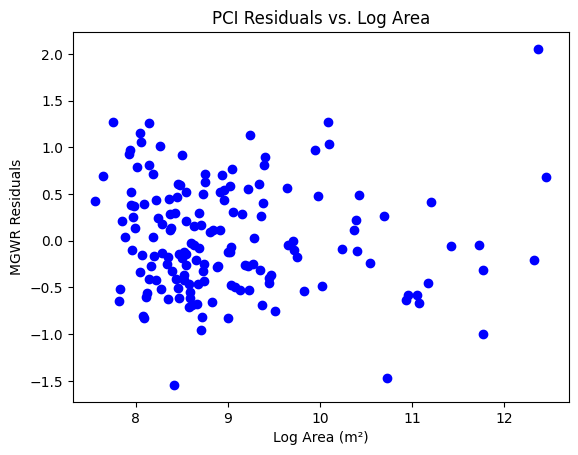

In [18]:
mgwr_residuals_pci = data_gdf['PCI'].values - mgwr_pci['model'].predy.flatten()
plt.scatter(data_gdf['log_area_m2'], mgwr_residuals_pci, c='blue')
plt.xlabel('Log Area (m²)')
plt.ylabel('MGWR Residuals')
plt.title('PCI Residuals vs. Log Area')
plt.show()

In [19]:
from scipy.stats import normaltest
stat, p = normaltest(mgwr_residuals_pci)
print(f"Residual Normality Test for PCI: statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05:
    print("  Residuals are not normally distributed, suggesting model limitations.")

Residual Normality Test for PCI: statistic = 3.9615, p-value = 0.1380


In [20]:
from scipy.stats import shapiro
stat, p = shapiro(mgwr_residuals_pci)
print(f"Shapiro-Wilk Normality Test for PCI: statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05:
    print("  Residuals are not normally distributed.")

Shapiro-Wilk Normality Test for PCI: statistic = 0.9828, p-value = 0.0472
  Residuals are not normally distributed.


### 3.3 PCE

In [21]:
# Run OLS regression for PCE
ols_pce = run_ols_regression(data_gdf, 'PCE', predictors, w, scaler)
print(f"\nOLS Summary for PCE:\n{ols_pce['summary']}")
print(f"Moran's I for residuals: {ols_pce['moran_i']:.4f}, p-value: {ols_pce['moran_p']:.4f}")
print(f"OLS AIC: {ols_pce['model'].aic:.4f}")


OLS Summary for PCE:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           1.05e-26
Time:                        23:35:24   Log-Likelihood:                -420.54
No. Observations:                 158   AIC:                             855.1
Df Residuals:                     151   BIC:                             876.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7022      0.2

In [22]:
# Run MGWR regression for PCE
mgwr_pce = run_mgwr_regression(data_gdf, 'PCE', predictors, coords, w, len(data_gdf), scaler)
print(f"\nMGWR Optimal Bandwidths for PCE: {mgwr_pce['bandwidths']}")
print(f"MGWR Summary for PCE:")
print(f"Global R2: {mgwr_pce['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_pce['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for PCE: [156.  46. 156. 133.  86. 156. 152.]
MGWR Summary for PCE:
Global R2: 0.6710
MGWR AIC: 847.4476


In [23]:
# Store MGWR results for PCE
store_mgwr_results(data_gdf, 'PCE', mgwr_pce, predictor_names)
print(f"Local R2 Proxy: {data_gdf['PCE_localR2_proxy'].mean():.4f}")  # Mean proxy value after storage

Local R2 Proxy: 0.6718


In [24]:
# Visualize MGWR residuals' spatial autocorrelation
mgwr_residuals_pce = data_gdf['PCE'].values - mgwr_pce['model'].predy.flatten()
moran_mgwr_pce = Moran(mgwr_residuals_pce, w)
print(f"MGWR Moran's I for PCE: {moran_mgwr_pce.I:.4f}, p-value: {moran_mgwr_pce.p_norm:.4f}")
if moran_mgwr_pce.p_norm < 0.05:
    print("Spatial autocorrelation is significant, justifying MGWR use, as per *Scientific Reports* (PAGE6).")

MGWR Moran's I for PCE: 0.1490, p-value: 0.0025
Spatial autocorrelation is significant, justifying MGWR use, as per *Scientific Reports* (PAGE6).


**PCE** results show:
- OLS:
    - R-squared: 0.587
    - AIC: 855.1 and BIC: 876.5
    - Moran’s I (0.0746, p = 0.1158): Non-significant, suggesting mild spatial autocorrelation, but the p-value is close to 0.05, supporting MGWR to capture local variations

- MGWR:
    - Global R²: 0.6710

### 3.4 PCA

In [25]:
# Run OLS regression for PCA
ols_pca = run_ols_regression(data_gdf, 'PCA', predictors, w, scaler)
print(f"\nOLS Summary for PCA:\n{ols_pca['summary']}")
print(f"Moran's I for residuals: {ols_pca['moran_i']:.4f}, p-value: {ols_pca['moran_p']:.4f}")


OLS Summary for PCA:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     26.06
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           3.89e-21
Time:                        23:35:58   Log-Likelihood:                -1725.8
No. Observations:                 158   AIC:                             3466.
Df Residuals:                     151   BIC:                             3487.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.025e+04   1091.7

In [26]:
# Run MGWR regression for PCA

mgwr_pca = run_mgwr_regression(data_gdf, 'PCA', predictors, coords, w, len(data_gdf), scaler)
print(f"\nMGWR Optimal Bandwidths for PCA: {mgwr_pca['bandwidths']}")
print(f"MGWR Summary for PCA:")
print(f"Global R2: {mgwr_pca['model'].R2:.4f}")
print(f"AIC: {mgwr_pca['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for PCA: [156. 156. 156. 138. 156. 156. 152.]
MGWR Summary for PCA:
Global R2: 0.5323
AIC: 3469.1773


In [27]:
# In 3.4 PCA after MGWR results
data_gdf['PCA_capped'] = data_gdf['PCA'].clip(lower=data_gdf['PCA'].quantile(0.05), upper=data_gdf['PCA'].quantile(0.95))
mgwr_pca_outlier = run_mgwr_regression(data_gdf, 'PCA_capped', predictors, coords, w, len(data_gdf), scaler)
print(f"Outlier-Adjusted MGWR R2 for PCA: {mgwr_pca_outlier['model'].R2:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Outlier-Adjusted MGWR R2 for PCA: 0.4218


In [28]:
# Store MGWR results for PCA
store_mgwr_results(data_gdf, 'PCA', mgwr_pca, predictor_names)
print(f"Local R2 Proxy: {data_gdf['PCA_localR2_proxy'].mean():.4f}")  # Mean proxy value after storage

Local R2 Proxy: 0.5323


In [29]:
# Visualize MGWR residuals' spatial autocorrelation
mgwr_residuals_pca = data_gdf['PCA'].values - mgwr_pca['model'].predy.flatten()
moran_mgwr_pca = Moran(mgwr_residuals_pca, w)
print(f"MGWR Moran's I for PCA: {moran_mgwr_pca.I:.4f}, p-value: {moran_mgwr_pca.p_norm:.4f}")
if moran_mgwr_pca.p_norm < 0.05:
    print("Spatial autocorrelation is significant, justifying MGWR use, as per *Scientific Reports* (PAGE6).")

MGWR Moran's I for PCA: 0.0928, p-value: 0.0541


In [30]:
# Investigate PCA's weaker performance
print("\nInvestigating PCA's Weaker Performance:")
print(f"PCA Global R2: {mgwr_pca['model'].R2:.4f} is lower than PCI and PCE, suggesting unmodeled factors.")
print(f"PCA AIC: {mgwr_pca['model'].aic:.4f} is high, indicating potential overfitting or missing variables.")
data_gdf['PCA_outliers'] = data_gdf['PCA'].abs() > data_gdf['PCA'].quantile(0.95)
print(f"Number of potential outliers: {data_gdf['PCA_outliers'].sum()}")


Investigating PCA's Weaker Performance:
PCA Global R2: 0.5323 is lower than PCI and PCE, suggesting unmodeled factors.
PCA AIC: 3469.1773 is high, indicating potential overfitting or missing variables.
Number of potential outliers: 8


**PCA** results show:
- OLS:
    - R-squared: 0.509 (moderate fit)
    - non-normal residuals
    - Moran’s I (0.0843, p = 0.0784): Borderline significant (p ≈ 0.05), suggesting mild spatial autocorrelation in residuals
- MGWR:
    - Global R²: 0.5323
    - Local R² Proxy: 0.5323 (identical to global R²) suggests uniform explanatory power,

## 4. Investigate Cooling vs. Heating Parks

In [31]:
# Categorize cooling vs. heating parks
data_gdf['PCI_group'] = data_gdf['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')
data_gdf['PCI_group'].value_counts()

PCI_group
Heating    117
Cooling     41
Name: count, dtype: int64

In [32]:
# Group parks by PCI
cooling_gdf = data_gdf[data_gdf['PCI_group'] == 'Cooling'].copy()
heating_gdf = data_gdf[data_gdf['PCI_group'] == 'Heating'].copy()

In [33]:
# Statistical comparison using t-test
from scipy.stats import ttest_ind
for metric in ['PCI', 'PCE', 'PCA']:
    t_stat, p_val = ttest_ind(cooling_gdf[metric].dropna(), heating_gdf[metric].dropna())
    print(f"\nT-test for {metric}: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print(f"  Significant difference between Cooling and Heating parks for {metric}.")


T-test for PCI: t-statistic = -9.8311, p-value = 0.0000
  Significant difference between Cooling and Heating parks for PCI.

T-test for PCE: t-statistic = 0.3707, p-value = 0.7113

T-test for PCA: t-statistic = -1.7488, p-value = 0.0823


## 5. LST (Within park) Regression

In [34]:
print(f"Average LST Reduction: {data_gdf['lst_reduction'].mean():.2f}°C")
print(f"Min/Max LST Reduction: {data_gdf['lst_reduction'].min():.2f}°C to {data_gdf['lst_reduction'].max():.2f}°C")

Average LST Reduction: 0.52°C
Min/Max LST Reduction: -1.20°C to 6.68°C


In [35]:
# Perform OLS and MGWR on LST Reduction to directly quantify cooling impact,
# aligning with *Scientific Reports* (PAGE10) LST difference and *Building and Environment* (PAGE14) microscale measurement.

# Run OLS regression for LST Reduction
ols_lst_reduction = run_ols_regression(data_gdf, 'lst_reduction', predictors, w, scaler)
print(f"\nOLS Summary for LST Reduction:\n{ols_lst_reduction['summary']}")
print(f"Moran's I for residuals: {ols_lst_reduction['moran_i']:.4f}, p-value: {ols_lst_reduction['moran_p']:.4f}")
print(f"OLS AIC: {ols_lst_reduction['model'].aic:.4f}")


OLS Summary for LST Reduction:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     24.06
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           7.33e-20
Time:                        23:40:04   Log-Likelihood:                -147.82
No. Observations:                 158   AIC:                             309.6
Df Residuals:                     151   BIC:                             331.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.523

In [36]:
# Run MGWR regression for LST Reduction
mgwr_lst_reduction = run_mgwr_regression(data_gdf, 'lst_reduction', predictors, coords, w, len(data_gdf), scaler)
print(f"\nMGWR Optimal Bandwidths for LST Reduction: {mgwr_lst_reduction['bandwidths']}")
print(f"MGWR Summary for LST Reduction:")
print(f"Global R2: {mgwr_lst_reduction['model'].R2:.4f}")
print(f"MGWR AIC: {mgwr_lst_reduction['model'].aic:.4f}")

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]


MGWR Optimal Bandwidths for LST Reduction: [ 91.  44. 156. 156. 152.  55. 156.]
MGWR Summary for LST Reduction:
Global R2: 0.7449
MGWR AIC: 238.8384


In [37]:
# Store MGWR results for LST Reduction
store_mgwr_results(data_gdf, 'lst_reduction', mgwr_lst_reduction, predictor_names)
print(f"Local R2 Proxy: {data_gdf['lst_reduction_localR2_proxy'].mean():.4f}")

Local R2 Proxy: 0.7459


In [38]:
# Visualize MGWR residuals' spatial autocorrelation
mgwr_residuals_lst = data_gdf['lst_reduction'].values - mgwr_lst_reduction['model'].predy.flatten()
moran_mgwr_lst = Moran(mgwr_residuals_lst, w)
print(f"MGWR Moran's I for LST Reduction: {moran_mgwr_lst.I:.4f}, p-value: {moran_mgwr_lst.p_norm:.4f}")
if moran_mgwr_lst.p_norm < 0.05:
    print("Spatial autocorrelation is significant, justifying MGWR use, as per *Scientific Reports* (PAGE6).")

MGWR Moran's I for LST Reduction: 0.0440, p-value: 0.3284


In [39]:
t_stat, p = ttest_ind(cooling_gdf['lst_reduction'].dropna(), heating_gdf['lst_reduction'].dropna())
print(f"T-test for LST Reduction: t-statistic = {t_stat:.4f}, p-value = {p:.4f}")

T-test for LST Reduction: t-statistic = -7.5223, p-value = 0.0000


**OLS Results**

OLS Results:
- R²: 0.489, AIC: 309.6313
- Moran’s I: 0.1369 (p = 0.0054) – Significant spatial autocorrelation, indicating OLS underestimates spatial variation

MGWR Results:
- R²: 0.7449, AIC: 238.8384, Local R² Proxy: 0.7459
- Moran’s I: 0.0440 (p = 0.3284) – Non-significant autocorrelation, indicating MGWR effectively captures spatial structure

t-statistic: -7.5223, p-value: 0.0000:
- Significant difference between Cooling and Heating parks, with Cooling parks showing higher LST reduction


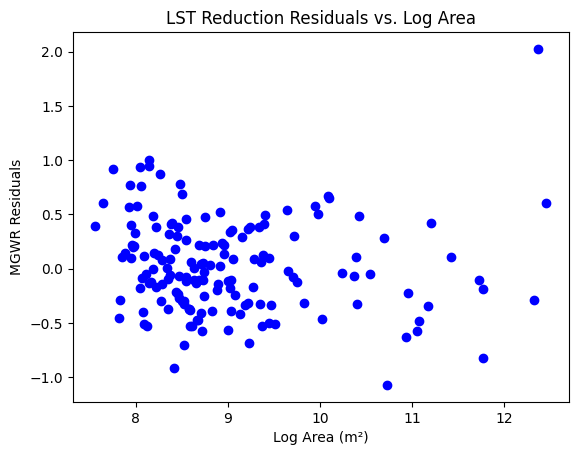

In [40]:
mgwr_residuals_lst = data_gdf['lst_reduction'].values - mgwr_lst_reduction['model'].predy.flatten()
plt.scatter(data_gdf['log_area_m2'], mgwr_residuals_lst, c='blue')
plt.xlabel('Log Area (m²)')
plt.ylabel('MGWR Residuals')
plt.title('LST Reduction Residuals vs. Log Area')
plt.show()

## 6. Data Export

In [41]:
# Drop centroid column to avoid multiple geometry columns
data_gdf = data_gdf.drop(columns=['centroid'])

# Spatial visualization preparation
data_gdf.to_file('Data/Riyadh_parks_with_all_variables.geojson', driver='GeoJSON')
print("Exported data to 'cooling_heating_parks.geojson' for QGIS visualization.")

INFO:pyogrio._io:Created 158 records


Exported data to 'cooling_heating_parks.geojson' for QGIS visualization.
